<a href="https://colab.research.google.com/github/Davydmunoz0/2_1_iris.ipynb/blob/main/2_1_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

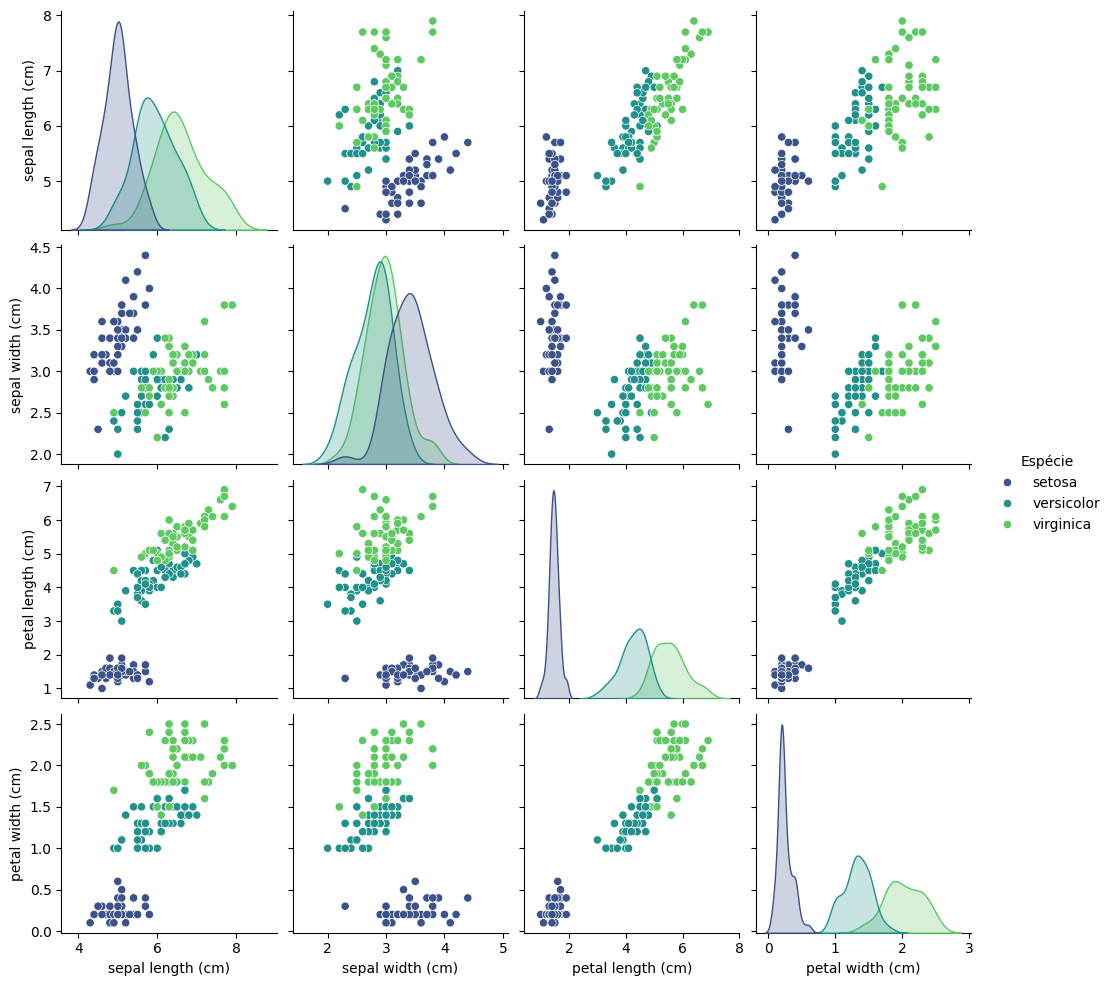

Dados originais: 150 amostras
Dados limpos: 149 amostras

           Avaliação Final dos Modelos            

=== SVM ===

Validação Cruzada (Acurácia):
Média: 0.98 | Desvio Padrão: 0.02

SVM Otimizado - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



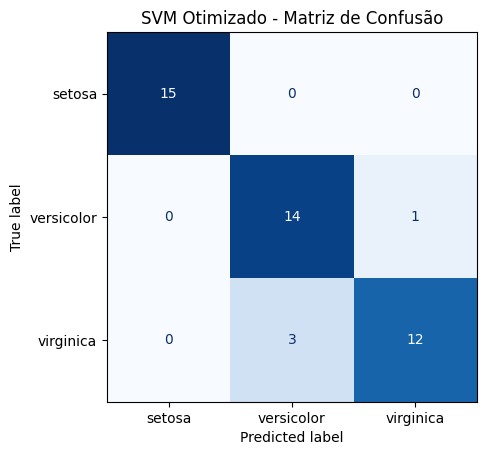

SVM Otimizado - ROC-AUC (OvR): 0.99


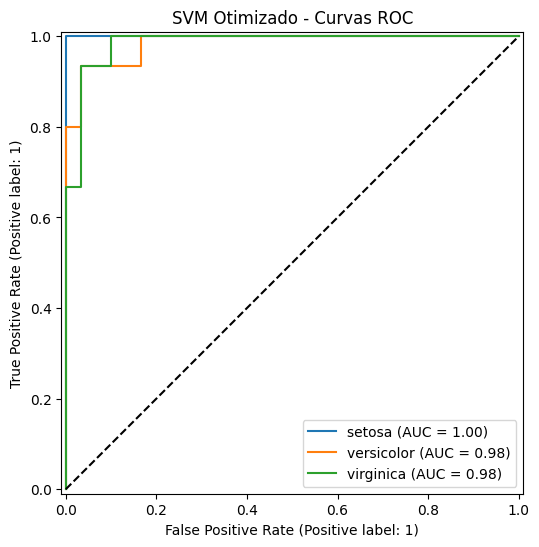


=== Árvore de Decisão ===

Validação Cruzada (Acurácia):
Média: 0.91 | Desvio Padrão: 0.05

Árvore Otimizada - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



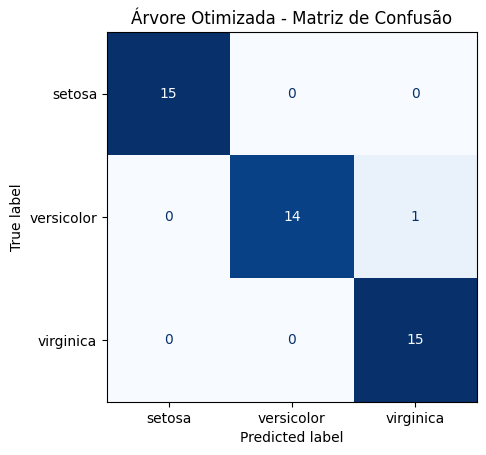

Árvore Otimizada - ROC-AUC (OvR): 0.99


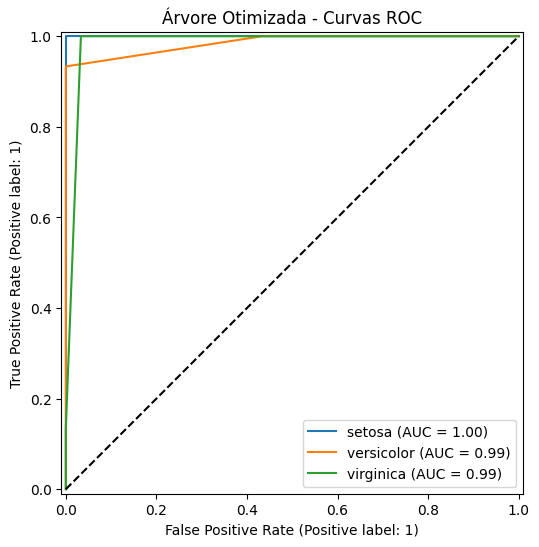


=== Gradient Boosting ===

Validação Cruzada (Acurácia):
Média: 0.97 | Desvio Padrão: 0.04

GB Otimizado - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



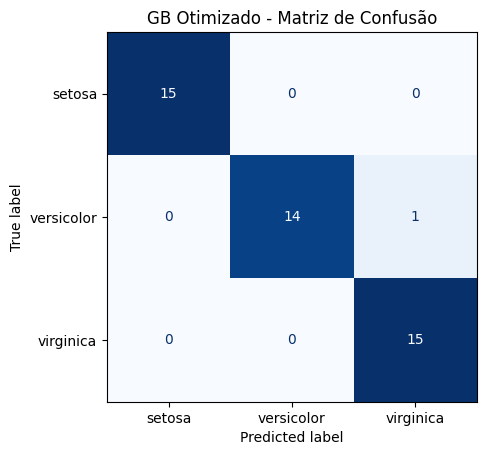

GB Otimizado - ROC-AUC (OvR): 0.99


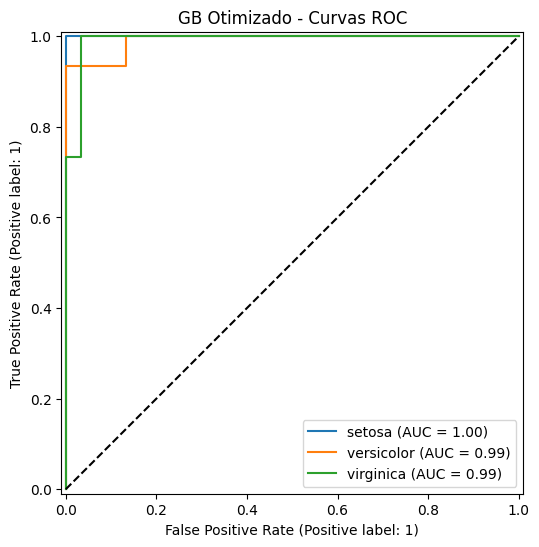

In [5]:
# Importações necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, confusion_matrix)
from sklearn.utils import resample

# Carregar dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# Análise Exploratória (EDA)
df_iris = pd.DataFrame(X, columns=feature_names)
df_iris['Espécie'] = y
df_iris['Espécie'] = df_iris['Espécie'].map({0: class_names[0], 1: class_names[1], 2: class_names[2]})
sns.pairplot(df_iris, hue='Espécie', palette='viridis')
plt.show()

# Pré-processamento aprimorado
def handle_outliers(X, y, threshold=3):
    """Remove outliers de forma conservadora mantendo a estrutura das classes"""
    z_scores = np.abs((X - X.mean(axis=0)) / X.std(axis=0))
    outliers_mask = (z_scores > threshold).any(axis=1)

    # Verifica balanceamento após remoção
    _, counts = np.unique(y[~outliers_mask], return_counts=True)
    if len(counts) < 3 or np.min(counts) < 10:
        return X, y  # Aborta se remover muitos dados

    return X[~outliers_mask], y[~outliers_mask]

# Aplica tratamento de outliers e verifica resultado
X_clean, y_clean = handle_outliers(X, y)
print(f"Dados originais: {X.shape[0]} amostras\nDados limpos: {X_clean.shape[0]} amostras")

# Divisão estratificada dos dados limpos
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.3,
    stratify=y_clean,  # Mantém proporção das classes
    random_state=42
)

# Padronização apenas para SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Função de avaliação aprimorada
def evaluate_model(model, X_test, y_test, class_names, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    print(f"\n{model_name} - Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                          display_labels=class_names,
                                          cmap='Blues',
                                          colorbar=False)
    plt.title(f'{model_name} - Matriz de Confusão')
    plt.show()

    if y_prob is not None:
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
        print(f"{model_name} - ROC-AUC (OvR): {roc_auc:.2f}")

        # Curvas ROC
        fig, ax = plt.subplots(figsize=(8,6))
        for i in range(len(class_names)):
            RocCurveDisplay.from_predictions(
                y_test_bin[:, i],
                y_prob[:, i],
                name=f"{class_names[i]}",
                ax=ax
            )
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{model_name} - Curvas ROC')
        plt.show()

# Validação cruzada estrita
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=cv), scoring='accuracy')
    print(f"\nValidação Cruzada (Acurácia):")
    print(f"Média: {scores.mean():.2f} | Desvio Padrão: {scores.std():.2f}")
    return scores

# Otimização de hiperparâmetros com prevenção de overfitting
def tune_model(model, param_grid, X, y, cv=5):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=cv),
        scoring='accuracy',
        n_jobs=-1,
        refit=True
    )
    grid.fit(X, y)
    return grid.best_estimator_, grid.best_params_

# SVM com kernel linear como padrão
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

best_svm, svm_params = tune_model(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    X_train_scaled,
    y_train
)

# Árvore de Decisão com parâmetros conservadores
dt_param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

best_dt, dt_params = tune_model(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    X_train,
    y_train
)

# Gradient Boosting simplificado
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.5],
    'max_depth': [3, 4]
}

best_gb, gb_params = tune_model(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    X_train,
    y_train
)

# Avaliação final com validação cruzada
print("\n" + "="*50)
print("Avaliação Final dos Modelos".center(50))
print("="*50)

# Avaliação do SVM
print("\n=== SVM ===")
cross_validate_model(best_svm, X_train_scaled, y_train)
evaluate_model(best_svm, X_test_scaled, y_test, class_names, "SVM Otimizado")

# Avaliação da Árvore de Decisão
print("\n=== Árvore de Decisão ===")
cross_validate_model(best_dt, X_train, y_train)
evaluate_model(best_dt, X_test, y_test, class_names, "Árvore Otimizada")

# Avaliação do Gradient Boosting
print("\n=== Gradient Boosting ===")
cross_validate_model(best_gb, X_train, y_train)
evaluate_model(best_gb, X_test, y_test, class_names, "GB Otimizado")